In [1]:
import tensorflow as tf
import keras 
from keras import layers
import numpy as np
from numba import cuda
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.utils import img_to_array, plot_model
import gc

In [2]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
color_img = []
gray_img = []
path = 'E:/TER/landscape Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
        if i == '7200.jpg':
            break
        else:    
            img = cv2.imread(path + '/'+i,1)
            img = cv2.resize(img, (SIZE, SIZE))
            # open cv reads images in BGR format so we have to convert it to LAB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
            #resizing image
            #分离图像通道
            l, a, b = cv2.split(img)
            xx=b
            #归一化
            l = (l/ 255.0)
            a = (a/ 255.0)
            b = (b/ 255.0)
            #合并通道
            img = cv2.merge([l, a, b])
            color_img.append(img_to_array(img))
            gray_img.append(img_to_array(l))
color_dataset=tf.data.Dataset.from_tensor_slices(np.array(color_img[0:20])).batch(20)
gray_dataset=tf.data.Dataset.from_tensor_slices(np.array(gray_img[0:20])).batch(20)
gc.collect()

100%|██████████| 7129/7129 [00:11<00:00, 633.49it/s]


0

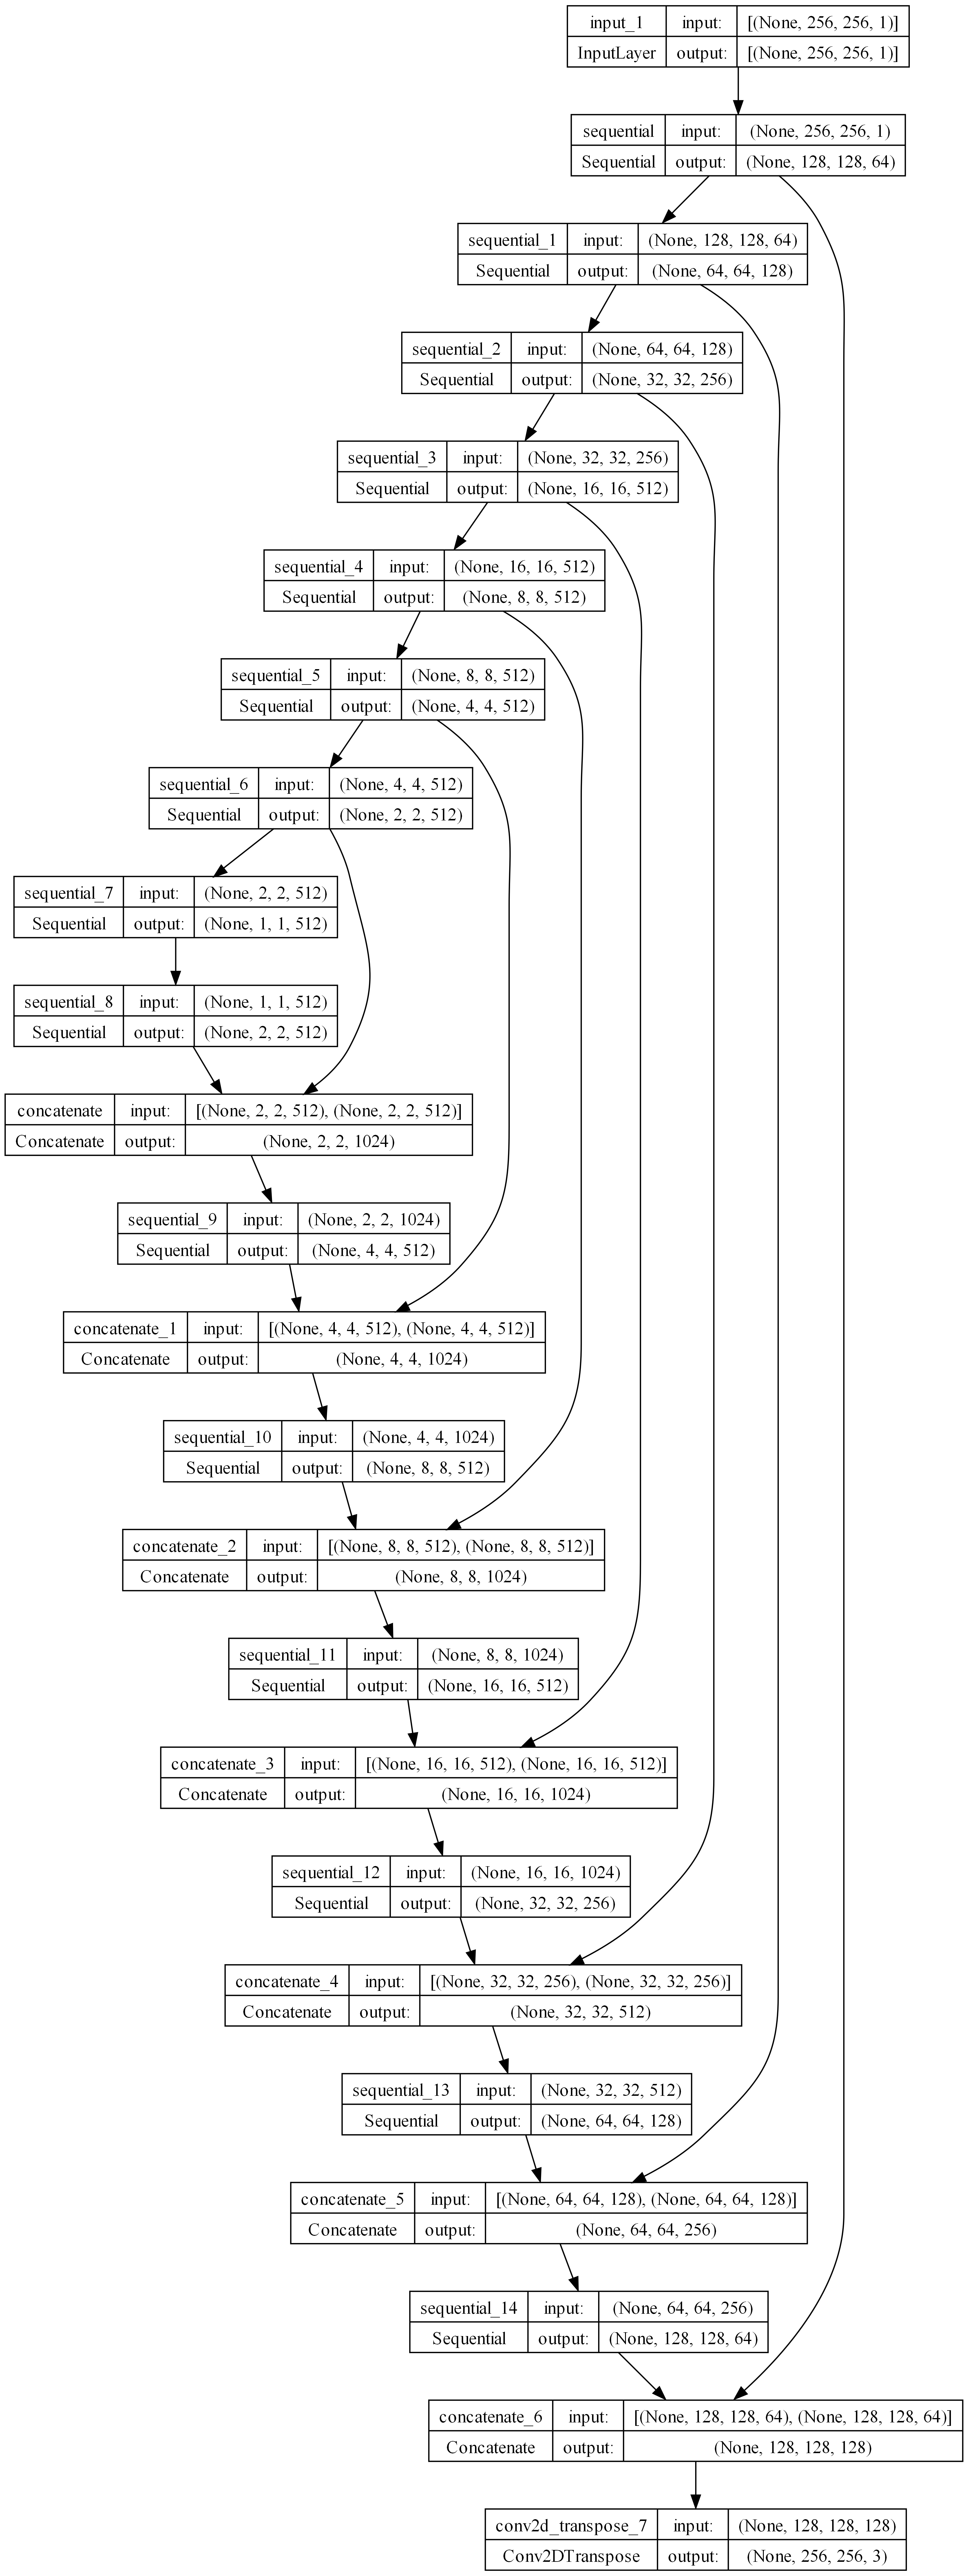

In [3]:
generator = keras.models.load_model('E:/TER/model/generator_lab.h5')
plot_model(generator, show_shapes=True, show_layer_names=True, dpi=320)
#f = open('E:/TER/landscape Images/generator.txt', 'w')
#清除文件中的内容
#f.truncate()

In [4]:
def generate_images(model, test_input, tar, n):
  prediction = model(test_input, training=False)
  plt.figure(figsize=(15,5))
  l, a, b = cv2.split(np.array(tar[0]))
  #归一化
  l = (l.astype('float32')* 100)
  a = (a.astype('float32')* 255.0)-128
  b = (b.astype('float32')* 255.0)-128
  #合并通道
  target_image = cv2.cvtColor(cv2.merge([l, a, b]), cv2.COLOR_LAB2RGB)  
  l, a, b = cv2.split(np.array(prediction[0]))
  #归一化
  l = (l.astype('float32')* 100)
  a = (a.astype('float32')* 255.0)-128
  b = (b.astype('float32')* 255.0)-128
  #合并通道
  prediction_image = cv2.cvtColor(cv2.merge([l, a, b]), cv2.COLOR_LAB2RGB)
  plt.imsave('E:/TER/Result_pix2pix_landscape_LAB/output/'+str(n)+'.png', target_image)
  display_list = [test_input[0], target_image, prediction_image]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  M = tf.keras.losses.MeanSquaredError()
  MSE = M(tar[0], prediction[0])
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i],cmap='gray')
    plt.axis('off')
  plt.suptitle("MSE: "+str(MSE.numpy()),fontsize=20)
  plt.imsave('E:/TER/Result_pix2pix_landscape_LAB/output/'+str(n)+".png", prediction_image)
  plt.savefig('E:/TER/Result_pix2pix_landscape_LAB/plot/'+str(n)+".png")
  plt.close()

In [5]:
with tqdm(total=7129) as pbar: 
  color_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(color_img[0:2000])).batch(1)
  gray_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(gray_img[0:2000])).batch(1)
  n = 0
  for example_input, example_target in tf.data.Dataset.zip((gray_dataset_t,color_dataset_t)):
    generate_images(generator, example_input, example_target,n)
    n = n + 1
    pbar.update(1)
  color_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(color_img[2000:4000])).batch(1)
  gray_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(gray_img[2000:4000])).batch(1)
  for example_input, example_target in tf.data.Dataset.zip((gray_dataset_t,color_dataset_t)):
    generate_images(generator, example_input, example_target,n)
    n = n + 1
    pbar.update(1)
  color_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(color_img[4000:6000])).batch(1)
  gray_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(gray_img[4000:6000])).batch(1)
  for example_input, example_target in tf.data.Dataset.zip((gray_dataset_t,color_dataset_t)):
    generate_images(generator, example_input, example_target,n)
    n = n + 1
    pbar.update(1)
  color_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(color_img[6000:7129])).batch(1)
  gray_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(gray_img[6000:7129])).batch(1)
  for example_input, example_target in tf.data.Dataset.zip((gray_dataset_t,color_dataset_t)):
    generate_images(generator, example_input, example_target,n)
    n = n + 1
    pbar.update(1)
#f.close()

100%|██████████| 7129/7129 [35:37<00:00,  3.34it/s]  
